In [3]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import ssl

In [4]:
ssl._create_default_https_context = ssl._create_unverified_context

newsdata = fetch_20newsgroups(subset= 'train')

In [5]:
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [7]:
print('훈련 샘플의 개수 : {}'.format(len(newsdata.data)))

훈련 샘플의 개수 : 11314


In [9]:
print('총 주제의 개수 : {}'.format(len(newsdata.target_names)))
print(newsdata.target_names)

총 주제의 개수 : 20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [10]:
data = pd.DataFrame(newsdata.data, columns = ['email'])
data['target'] = pd.Series(newsdata.target)
data.head()

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 132.7+ KB


In [12]:
data.isnull().values.any()

False

In [13]:
print('중복을 제외한 샘플의 개수 : {}'.format(data['email'].nunique()))
print('중복을 제외한 주제의 수 : {}'.format(data['target'].nunique()))

중복을 제외한 샘플의 개수 : 11314
중복을 제외한 주제의 수 : 20


<AxesSubplot:>

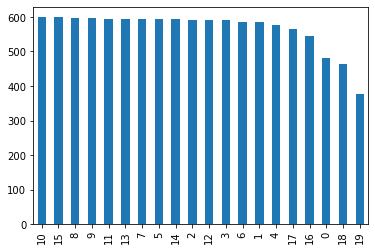

In [16]:
data['target'].value_counts().plot(kind = 'bar')

In [17]:
print(data.groupby('target').size().reset_index(name = 'count'))

    target  count
0        0    480
1        1    584
2        2    591
3        3    590
4        4    578
5        5    593
6        6    585
7        7    594
8        8    598
9        9    597
10      10    600
11      11    595
12      12    591
13      13    594
14      14    593
15      15    599
16      16    546
17      17    564
18      18    465
19      19    377


In [18]:
newsdata_test = fetch_20newsgroups(subset= 'test')
train_email = data['email']
train_label = data['target']

test_email = newsdata_test.data
test_label = newsdata_test.target

In [19]:
max_word = 10000
num_classes = 20

In [26]:
def prepare_data(train_data, test_data, mode):
    t = Tokenizer(num_words = max_word)
    t.fit_on_texts(train_data)
    x_train = t.texts_to_matrix(train_data, mode = mode)
    x_test = t.texts_to_matrix(test_data, mode = mode)

    return x_train, x_test, t.index_word

In [28]:
x_train, x_test, index_to_word = prepare_data(train_email, test_email, 'binary')
y_train = to_categorical(train_label)
y_test = to_categorical(test_label)

In [29]:
print('train sample size : {}'.format(x_train.shape))
print('test sample size : {}'.format(x_test.shape))
print('train label size : {}'.format(y_train.shape))
print('test label size : {}'.format(y_test.shape))

train sample size : (11314, 10000)
test sample size : (7532, 10000)
train label size : (11314, 20)
test label size : (7532, 20)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [31]:
def fit_and_evaluate(x_train, y_train, x_test, y_test):
    model = Sequential()
    model.add(Dense(256, input_shape = (max_word,), activation= 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
    model.fit(x_train, y_train, batch_size = 128, epochs = 5, verbose = 1, validation_split = 0.1)
    score = model.evaluate(x_test, y_test, batch_size = 128, verbose = 0)
    return score[1]

In [34]:
modes = ['binary', 'count', 'tfidf', 'freq']

for mode in modes:
    x_train, x_test, _ = prepare_data(train_email, test_email, mode)
    score = fit_and_evaluate(x_train, y_train, x_test, y_test)
    print(mode + ' 모드의 테스트 정확도 : {}'.format(score))

Epoch 1/5
80/80 [==============================] - 3s 23ms/step - loss: 2.2517 - acc: 0.3473 - val_loss: 0.9424 - val_acc: 0.8216
Epoch 2/5
80/80 [==============================] - 2s 20ms/step - loss: 0.8426 - acc: 0.7676 - val_loss: 0.4566 - val_acc: 0.8843
Epoch 3/5
80/80 [==============================] - 2s 22ms/step - loss: 0.4392 - acc: 0.8830 - val_loss: 0.3608 - val_acc: 0.8984
Epoch 4/5
80/80 [==============================] - 2s 24ms/step - loss: 0.2684 - acc: 0.9320 - val_loss: 0.3112 - val_acc: 0.9081
Epoch 5/5
80/80 [==============================] - 2s 24ms/step - loss: 0.1763 - acc: 0.9568 - val_loss: 0.3116 - val_acc: 0.9055
binary 모드의 테스트 정확도 : 0.8272703289985657
Epoch 1/5
80/80 [==============================] - 4s 27ms/step - loss: 2.8652 - acc: 0.2213 - val_loss: 1.7672 - val_acc: 0.7032
Epoch 2/5
80/80 [==============================] - 2s 24ms/step - loss: 1.5238 - acc: 0.6072 - val_loss: 0.7569 - val_acc: 0.8472
Epoch 3/5
80/80 [==============================] -

In [35]:
import numpy as np
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional


In [36]:
train_x = [[0.1, 4.2, 1.5, 1.1, 2.8], [1.0, 3.1, 2.5, 0.7, 1.1], [0.3, 2.1, 1.5, 2.1, 0.1], [2.2, 1.4, 0.5, 0.9, 1.1]]
print(np.shape(train_x))

(4, 5)


In [37]:
train_x = [train_x]
train_x = np.array(train_x, dtype = np.float32)
print(train_x.shape)

(1, 4, 5)


In [38]:
rnn = SimpleRNN(3)
hidden_state = rnn(train_x)
print('hidden state :{}, shape : {}'.format(hidden_state, hidden_state.shape))

hidden state :[[ 0.86186093 -0.55154276  0.9986222 ]], shape : (1, 3)


In [39]:
rnn = SimpleRNN(3, return_sequences=True)
hidden_state = rnn(train_x)

print('hidden state : {}, shape : {}'.format(hidden_state, hidden_state.shape))

hidden state : [[[-0.9951869   0.99402773  0.31996372]
  [-0.9911536   0.9920929  -0.55236167]
  [-0.9578821   0.9558894   0.79862297]
  [-0.9938752   0.9621945   0.5863987 ]]], shape : (1, 4, 3)


In [40]:
import pandas as pd
from string import punctuation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.utils import to_categorical

In [41]:
df = pd.read_csv('C:/Users/Windows10/Desktop/코딩/data/newyorktimes/ArticlesApril2018.csv')
df.head()

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


In [42]:
print('열의 개수 :', len(df.columns))

열의 개수 : 15


In [43]:
df['headline'].isnull().values.any()

False

In [44]:
headline = []
headline.extend(list(df.headline.values))
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

In [45]:
print('all samples : {}'.format(len(headline)))

all samples : 1324


In [46]:
headline = [n for n in headline if n != 'Unknown']
print('number of samples after delete "Unknown" : {}'.format(len(headline)))

number of samples after delete "Unknown" : 1214


In [47]:
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?']

In [48]:
def repreprocessing(s):
    s = s.encode('utf8').decode("ascii", 'ignore')
    return ''.join(c for c in s if c not in punctuation).lower()

text = [repreprocessing(x) for x in headline]
text[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

In [49]:
t = Tokenizer()
t.fit_on_texts(text)
vocab_size = len(t.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))

단어 집합의 크기 : 3494


In [50]:
sequences = []

for line in text:
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

In [51]:
index_to_word = {}
for key, value in t.word_index.items():
    index_to_word[value] = key


print('빈도수 상위 582번 단어 : {}'.format(index_to_word[582]))

빈도수 상위 582번 단어 : offer


In [52]:
max_len = max(len(l)for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 24


In [53]:
sequences = pad_sequences(sequences, maxlen = max_len, padding = 'pre')
print(sequences[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371 1115]]


In [54]:
sequences = np.array(sequences)
x = sequences[:, :-1]
y = sequences[:, -1]

In [55]:
print(x[:3])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  99]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  99 269]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  99 269 371]]


In [56]:
y[:3]

array([ 269,  371, 1115])

In [57]:
y = to_categorical(y, num_classes= vocab_size)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

In [59]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length= max_len))
model.add(LSTM(128))
model.add(Dense(vocab_size, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
model.fit(x, y, epochs = 200, verbose = 2)

Epoch 1/200
244/244 - 7s - loss: 7.6359 - acc: 0.0302
Epoch 2/200
244/244 - 4s - loss: 7.1186 - acc: 0.0308
Epoch 3/200
244/244 - 5s - loss: 6.9772 - acc: 0.0360
Epoch 4/200
244/244 - 5s - loss: 6.8528 - acc: 0.0400
Epoch 5/200
244/244 - 5s - loss: 6.7049 - acc: 0.0418
Epoch 6/200
244/244 - 5s - loss: 6.5350 - acc: 0.0432
Epoch 7/200
244/244 - 5s - loss: 6.3404 - acc: 0.0514
Epoch 8/200
244/244 - 5s - loss: 6.1496 - acc: 0.0555
Epoch 9/200
244/244 - 5s - loss: 5.9593 - acc: 0.0620
Epoch 10/200
244/244 - 5s - loss: 5.7749 - acc: 0.0624
Epoch 11/200
244/244 - 5s - loss: 5.5968 - acc: 0.0692
Epoch 12/200
244/244 - 5s - loss: 5.4272 - acc: 0.0770
Epoch 13/200
244/244 - 6s - loss: 5.2671 - acc: 0.0795
Epoch 14/200
244/244 - 5s - loss: 5.1126 - acc: 0.0852
Epoch 15/200
244/244 - 5s - loss: 4.9676 - acc: 0.0966
Epoch 16/200
244/244 - 5s - loss: 4.8256 - acc: 0.1087
Epoch 17/200
244/244 - 7s - loss: 4.6920 - acc: 0.1184
Epoch 18/200
244/244 - 6s - loss: 4.5608 - acc: 0.1341
Epoch 19/200
244/24

In [60]:
def sentence_generation(model, t, current_word, n):
    init_word = current_word
    sentence = ''

    for _ in range(n):
        encoded = t.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen = max_len, padding = 'pre')
        result = model.predict_classes(encoded, verbose= 0)

        for word, index in t.word_index.items():
            if index == result:
                break
        current_word = current_word + ' ' + word
        sentence = sentence + ' ' + word
    
    sentence = init_word + sentence
    return sentence

In [61]:
print(sentence_generation(model, t, 'i', 10))

C:\Users\Windows10\anaconda3\envs\tf_2.0\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


i want to be rich and im not sorry pruitts ethics


In [62]:
print(sentence_generation(model, t, 'how', 10))

C:\Users\Windows10\anaconda3\envs\tf_2.0\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


how to make a crossword puzzle dream has the church battle


In [63]:
print(sentence_generation(model, t, 'war', 100))

C:\Users\Windows10\anaconda3\envs\tf_2.0\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


war metoo should the jokes were using column tackle next losing police up one can can epa about it to kings client law smart free to second reimaginedjurassic classics dying classics dying as megaproblems ethics future student real fix how an was very support for the arabian peninsula real chief us a bear strike spotlight songs songs later megaproblems later means megaproblems secret own others secret gut phone reimaginedjurassic raging gut gut democracy of later reimaginedjurassic from the global thing and home chief been her sell adds become best reimaginedjurassic classics nature and megaproblems reimaginedjurassic classics nature and historyancient history reimaginedjurassic
